# Biofysikkprosjekt - Monte Carlo-simuleringer av polymerfolding

Vemund Aakre, Thorbjørn Djupvik og Oskar Feed Jakobsen

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.constants import Boltzmann
from pathlib import Path

---

I grove trekk er proteinar bygd opp av aminosyrer i lange kjedar.
Desse vil folde seg i det tredimensjonale rommet og ulike ledd i kjeden vil kunne vekselvirke seg imellom.
Generaliseringen av slike strukturar blir kalla polymerar. Polymerane består av repeterande einingar som blir kalla monomerar.
I dette prosjektet ser me på polymerfolding i to dimensjonar.
Me ynskjer å bruke Monte Carlo-simuleringar for å undersøke fysiske eigenskapar til slike strukturar.
Energi, romleg utstrekning og temperaturavhengigheiten til desse er størrelsar som skal undersøkast.

---

For å representere eit todimensjonalt polymer kan ein nytta seg av eit kartesisk 
koordinatsystem og representere kvar monomer med eit koordinat. Polymeret kan dermed 
representerast med ein $N\times2$-matrise, kor kvar rad inneheld koordinatane til monomerane i 
riktig rekkjefølgje:

$$
  \begin{bmatrix}
   x_1& y_1\\
   x_2& y_2\\
   \vdots&\vdots \\
   x_N& y_N\\
  \end{bmatrix}
$$

Då er det også hensiktsmessig å definere ei retning på monomeren. Hovudet 
til polymeren definerer me som $(x_1, y_1)$ i polymer-matrisa. Halen blir dermed $(x_N, y_N)$.

Funksjonen `generate_flat_polymer` genererar ein slik polymer med senter i origo.

In [2]:
def generate_flat_polymer(
    polymer_length: int, mid_of_polymer: np.ndarray = np.zeros(2)
) -> np.ndarray:
    """Genererer en horisontal polymer med N monomerer

    Args:
        polymer_length (int): N antall monomerer
        mid_of_polymer (np.ndarray, optional): Midtpunktet til polymeren, Defaults to np.zeros(2).

    Returns:
        np.ndarray: den genererte polymeren
    """
    polymer_array = np.zeros((polymer_length, 2), dtype=np.int32)
    polymer_start = -int(polymer_length / 2) + mid_of_polymer[0]
    # + 1/2 for å håndtere partall
    polymer_end = int((polymer_length + 1) / 2) + mid_of_polymer[0]
    polymer_array[:, 1] = mid_of_polymer[1]
    polymer_array[:, 0] = np.arange(polymer_start, polymer_end, 1, dtype=np.int32)

    return polymer_array

Undervegs vil det vere fint å kunne visualisere korleis polymeren ser ut. Funksjonen `illustrate_polymer` er ein måte å implementere dette på.

In [27]:
def illustrate_polymer(
    polymer: np.ndarray,
    cmap: str = "binary",
    numbers: bool = False,
    title: str = "",
    save_to_file: bool = False,
    filename: str | Path = "",
) -> None:
    """
    Uses matplotlib.pyplot.pcolormesh to illustrate a polymer.

    Args:
        polymer: Nx2-dimensional array containing coordinates for the N monomers
        cmap: matplotlib colormap
        number: Defaults to False. If True the monomers will display their index
        title: Title
        save_to_file: Defaults to False
        filename: if save_to_file is True filename has to be specified.

    Returns:
        None
    """
    fig, ax = plt.subplots()

    # Make a NxN-grid
    N = len(polymer)
    x = y = np.arange(N + 1)
    Z = np.zeros((N, N))

    # Placing the polymer on the grid such that the middle monomer is in the center.
    middle_monomer = polymer[int(N / 2)]
    for i, monomer in enumerate(polymer):
        shifty = 1 if N % 2 == 0 and middle_monomer[1] < 0 else 0
        shiftx = 1 if N % 2 == 0 and middle_monomer[0] < 0 else 0
        x_coord = monomer[1] + int(N / 2) - middle_monomer[1] - shifty
        y_coord = monomer[0] + int(N / 2) - middle_monomer[0] - shiftx
        Z[x_coord, y_coord] = N + 2 - i
        if numbers:
            ax.text(y_coord + 0.5, x_coord + 0.5, i + 1, size="large", color="red")

    ax.pcolormesh(x, y, Z, shading="flat", cmap=cmap)
    ax.set(title=title, xticks=x, xticklabels=[], yticks=y, yticklabels=[])
    plt.tick_params(axis="both", left=False, right=False, bottom=False, top=False)
    ax.grid()

    if not save_to_file:
        plt.show()
    else:
        print(
            f"function illustrate_polymer() in {__file__}:\n\tsaving a plot to {filename}"
        )
        plt.savefig(filename)

La oss bruke `illustrate_polymer` til å sjå korleis ein flat polymer med lengde 10 ser ut. Nummereringa $1$-$10$ går frå hovudet til halen.

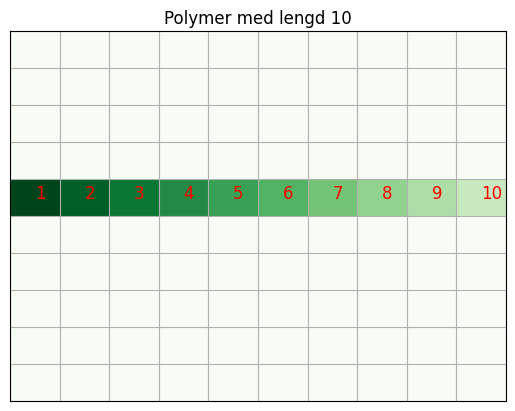

In [28]:
polymer = generate_flat_polymer(polymer_length=10)
illustrate_polymer(polymer, numbers=True, cmap="Greens", title="Polymer med lengd 10")

Eit polymer er *intakt* om det oppfyller dei tre krava i deloppgåve 1e):

**sitere?**
1. Det har $N$ monomerer.
2. Hver monomer representeres av et unikt heltall $m \in [1, N]$. Det vil si at ingen monomerer representeres av det samme tallet som en annen monomer.
3. En monomer representert av tallet $m$ skal være nærmeste nabo med monomerene
representert av tallene $m−1$ og $m+1$. Endemonomerene $m = 1$ og $m = N$ trenger kun å være nærmeste nabo med henholdsvis $m = 2$ og $m = N − 1$.




In [5]:
def check_if_intact(polymer: np.ndarray, polymer_length: int) -> bool:
    """Sjekker om en polymer er intakt

    Args:
        polymer (np.ndarray): polymeren som sjekkes
        polymer_length (int): lengden til polymeren

    Returns:
        bool: True hvis polymeren er intakt
    """
    if np.size(np.unique(polymer, axis=0), axis=0) != polymer_length:
        return False  # Sjekker både at den har N monomerer og at de alle har en unik heltallsrepresentasjon

    for i in range(1, polymer_length):
        distance = (polymer[i - 1, 0] - polymer[i, 0]) ** 2 + (
            polymer[i - 1, 1] - polymer[i, 1]
        ) ** 2  ## Trenger ikke kvadratrot fordi alt annet enn 1 som verdi er ikke intakt(også raskere)
        distance = (polymer[i - 1, 0] - polymer[i, 0]) ** 2 + (
            polymer[i - 1, 1] - polymer[i, 1]
        ) ** 2  ## Trenger ikke kvadratrot fordi alt annet enn 1 som verdi er ikke intakt(også raskere)
        if distance != 1:
            return False
    return True

Når ein skal rotere eit polymer om eit bestemt monomer, treng ein kun å sjå på den relative 
posisjonen til kvart monomer i rotasjonspolymeret i forhold til rotasjonssentrumet. Viss 
monomeret er representert ved koordinatet (a, b) med origo i rotasjonssentrumet. Då vil den 
roterte monomeren sine koordinatar vere gitt ved (-b, a) for positiv retning, og (b, -a) for 
negativ retning. I forhold til det originale koordinatsystemet vil monomeren vere representert 
ved $(x_s + x_\text{rel}, y_s + y_\text{rel})$, kor $(x_s, y_s)$ er posisjonen til rotasjonssenteret. Den 
roterte monomeren blir då $(x_s - y_\text{rel}\cdot k, y_s + x_\text{rel} \cdot k) $, kor $k=1$ for positiv 
retning, og $k=-1$ for negativ retning. Uttrykt ved koordinatane til monomeren og 
rotasjonssenteret: $$(x_\text{rot}, y_\text{rot}) = (x_s, y_s) + (-(y_0 - y_s), x_0 - x_s) \cdot k $$

Ein optimalisering ein kan gjere når ein skal rotere eit polymer, er at ein kun roterer den kortaste biten. Viss ein skal rotere rundt monomeren i midten, har det ingenting å sei kva for ein vei ein roterar det.

In [6]:
def rotate_polymer_tail(
    polymer: np.ndarray, rotation_center: int, positive_direction: bool
) -> np.ndarray:
    """Roterer halen til et polymer rundt rotasjonssenteret i en gitt retning

    Args:
        polymer: Et 2D numpy array med monomer-koordinatene

        rotation_center: Hvilket monomer man skal rotere rundt.
        Merk: Det er ikke indeks, men polymer nummeret [1, N]

        positive_direction: Rotere i positiv retning. Hvis False roteres det i negativ retning.

    Returns:
        en rotert kopi av polymeret
    """
    if positive_direction:
        direction = 1
    else:
        direction = -1

    # Rotasjonssentrum sine koordinater
    rotation_position = polymer[rotation_center - 1]

    # Med _rel menes posisjonen relativt rotasjonssenteret
    # new_x = x_s + new_x_rel
    # new_y = y_s + new_y_rel
    # new_x_rel = - (y - y_s) * direction
    # new_y_rel = (x - x_s) * direction
    new_pos_rel = ((polymer[rotation_center:] - rotation_position) * direction)[:, ::-1]
    new_pos_rel[:, 0] *= -1  # Endrer fortegnet til x-ene

    # Lager kopi av polymeret
    # om lettere å mutere for så å mutere tilbake igjen
    # new_polymer = polymer[:]
    new_polymer = polymer.copy()

    new_polymer[rotation_center:] = rotation_position + new_pos_rel
    return new_polymer

In [7]:
def rotate_polymer_head(
    polymer: np.ndarray, rotation_center: int, positive_direction: bool
) -> np.ndarray:
    """Roterer halen til et polymer rundt rotasjonssenteret i en gitt retning

    Args:
        polymer: Et 2D numpy array med monomer-koordinatene

        rotation_center: Hvilket monomer man skal rotere rundt.
        Merk: Det er ikke indeks, men polymer nummeret. [1, N]

        positive_direction: Rotere i positiv retning. Hvis False roteres det i negativ retning.

    Returns:
        en rotert kopi av polymeret
    """
    # For kommentarer se rotate_polymer_tail
    if positive_direction:
        direction = 1
    else:
        direction = -1

    rotation_position = polymer[rotation_center - 1]
    new_pos_rel = ((polymer[:rotation_center] - rotation_position) * direction)[:, ::-1]
    new_pos_rel[:, 0] *= -1

    # om lettere å mutere for så å mutere tilbake igjen
    # new_polymer = polymer[:]
    new_polymer = polymer.copy()

    new_polymer[:rotation_center] = rotation_position + new_pos_rel
    return new_polymer

In [8]:
def rotate_polymer(
    polymer: np.ndarray, rotation_center: int, positive_direction: bool = True
) -> np.ndarray:
    """Roterer et polymer rundt rotasjonssenteret i en gitt retning.

    Args:
        polymer: Et 2D numpy array med monomer-koordinatene

        rotation_center: Hvilket monomer man skal rotere rundt.
        Merk at det er ikke indeks, men polymer nummeret [1, N]

        positive_direction: Rotere i positiv retning. Hvis False roteres det i negativ retning.

    Returns:
        en rotert kopi av polymeret
    """

    if (
        rotation_center >= len(polymer) / 2
    ):  # Velger å rotere den delen av polymeret som er kortest
        return rotate_polymer_tail(polymer, rotation_center, positive_direction)
    else:
        return rotate_polymer_head(polymer, rotation_center, positive_direction)

Implenetasjon av algoritme 1 (**sitere?**):

In [16]:
def alg1(N: int, Ns: int) -> tuple[np.ndarray, int]:
    """Implementation of algorithm 1.
    ---
    Args:
        N: length of polymer.
        Ns: number of twists (attempts) to be performed.

    Returns:
        (polymer, counter)
            polymer: polymer.
            counter: number of successful twists.
    """
    counter = 1
    pol = generate_flat_polymer(N)
    for i in range(Ns):
        # random monomer and random twisting direction
        rnd_monomer = np.random.randint(2, N)
        rnd_rotate = bool(int(np.random.uniform() + 0.5))

        # TODO: possible to mutate the same array instead of copying?
        twisted_pol = rotate_polymer(pol, rnd_monomer, rnd_rotate)
        if check_if_intact(twisted_pol, N):
            counter += 1
            pol = twisted_pol

    return pol, counter

La oss køyre `alg1` og visualisere resultatet. Først med $N = 15$ og $N_s = 4$. Deretter $N = 15$ og $N_s = 1000$. 

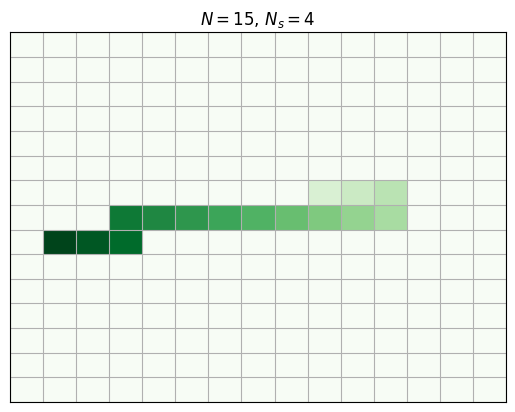

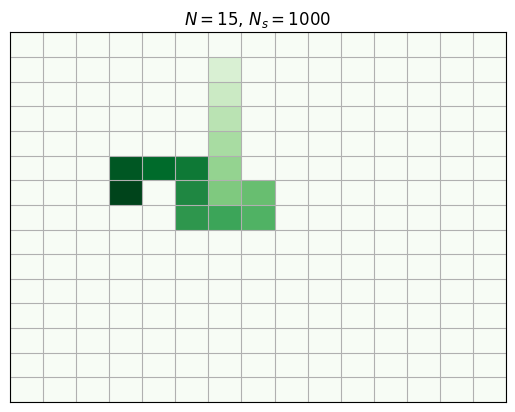

In [29]:
polymer_1, _ = alg1(N = 15, Ns = 4)
polymer_2, _ = alg1(N = 15, Ns = 1000)

illustrate_polymer(polymer_1, cmap="Greens", title="$N = 15$, $N_s = 4$")
illustrate_polymer(polymer_2, cmap="Greens", title="$N = 15$, $N_s = 1000$")

Det er nå eit godt tidspunkt å vurdera hastigheita til funksjonane som er implementert.

**insert episk innhold her**

La oss sjekke tidsbruken:

**%timeit eller egendefinerte benchmarks?**

**Korleis skalerar implementasjonen med $N$?**

In [24]:
%timeit alg1(N = 15, Ns = 1000)

90.7 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Energien til polymeren er definert slik:

$$
    E = \frac{1}{2} \sum_{m, n} V_{mn} b_{mn}
$$

**sjå prosjektbeskrivelse for forklaring. Kor mykje treng vi å inkludere her for at teksten skal ha god samanheng og flyt?**

Her er $N\times N$-matrisen $V$ ein konstant (som kan definerast på forhand) medan størrelsen $b_{mn}$ må reknast ut for kvar iterasjon:

\begin{equation}
 b_{mn} =
  \begin{cases}
  1 & m \text{ og } n \text{ nærmaste naboar} \\
  0 & \text{ellers} 
  \end{cases}
\end{equation}

For å rekne ut energien til eit monomer treng ein å vite kven av monomerane som er nærmaste naboar.

Me har to implementasjonar som har ulike styrkar og svakheiter:

- `calculate_energy`:
    - neg: brukar `for`-løkker. pos: utnyttar symmetrien til $V$ og $b$.
- `calculate_energy_2`
    - neg: brukar meir minne. pos: brukar utelukkande `numpy` og er dermed ein smule raskare
 
**visa til benchmarks og testing av hastigheit og minnebruk?** 

In [10]:
# Funksjonen kan, (og bør?), JIT-kompileres av numba
@njit()
def calculate_energy(polymer: np.ndarray, V: np.ndarray) -> np.float32:
    """Regner ut energien til et gitt polymer.

    Args:
        polymer: et numpy-array med monomer-koordinatene til et gyldig polymer

        V: matrise med styrken på vekselvirkninger mellom monomerene.
        V[i, j] = V[j, i] = styrken mellom monomer nummer (i+1) og (j+1)

    Returns:
        Energien til hele polymeret
    """
    N = len(polymer)
    # En matrise som angir om monomer (i+1) og (j+1) er naboer. b_matrix[i, j] = 1 dersom de er naboer.
    b_matrix = np.zeros((N, N))
    for i in range(0, N):
        # Trenger kun å se på monomer-sammensetninger som ikke har blitt sjekket enda.
        # Nabomonomeren er alltid en nabo uten vekselvirkning, så trenger ikke sjekke den.
        for j in range(i + 2, N):
            # Kun nærmeste-nabo koordinater gir en euklidsk avstand på nøyaktig 1.
            if np.sum((polymer[i] - polymer[j]) ** 2) == 1:
                # Trenger bare fylle den nedre trekanten av matrisen,
                # siden den ellers ville vært symmetrisk. (Merk j>i)
                b_matrix[j, i] = 1
    # Trenger ikke dele på 2 siden vi bare fyller ut den nedre trekanten av b_matrix;
    # vi dobbelteller ikke.
    return np.sum(V * b_matrix)

In [25]:
@njit
def calculate_energy_2(polymer: np.ndarray, V: np.ndarray) -> float:
    """idk... think it works. maybe. see Oskar's notebook for details lol."""
    N = len(polymer)
    L = np.repeat(polymer, N).reshape(2*N,N)
    b = np.where(np.abs(L[::2] - L[::2].transpose()) + np.abs(L[1::2] - L[1::2].transpose()) == 1, 1, 0)
    return 0.5*(np.sum(V*b))

---

## Oppgåve 2

**nødvendig med veldig utførleg forklaring her?**

In [11]:
def metropolis(
    pol: np.ndarray, N_s: int, V: np.ndarray, T: float
) -> tuple[np.ndarray, np.ndarray]:
    """Kjører metropolis-algoritmen som beskrevet i oppgaveheftet

    Args:
        pol: polymer starttilstand
        N_s: Antall forsøk på rotasjon
        V: Vekselvirkningene mellom to gitte monomerer
        T: temperaturen i kelvin

    Returns:
        (Siste polymer , array med alle energiene som ble simulert)
    """
    E_array = np.zeros(N_s)
    N = len(pol)
    E = polymer.calculate_energy(pol, V)
    i = 0
    while i < N_s - 1:
        # random monomer and random twisting direction
        rnd_monomer = np.random.randint(2, N)
        rnd_rotate = bool(int(np.random.uniform() + 0.5))

        # TODO: possible to mutate the same array instead of copying?
        twisted_pol = polymer.rotate_polymer(pol, rnd_monomer, rnd_rotate)
        if polymer.check_if_intact_2(twisted_pol, N):
            i += 1
            E_new = polymer.calculate_energy(twisted_pol, V)

            if E_new < E:
                pol = twisted_pol
                E = E_new
            # TODO: Bruke en annen distribusjon enn uniform?
            # TODO: Boltzmann-konstanten er liten. Sjekk at python håndterer det.
            elif np.random.uniform() < np.exp(-(E_new - E) / (T * Boltzmann)):
                pol = twisted_pol
                E = E_new
            E_array[i] = E

    return pol, E_array

La oss køyre to simuleringar av `metropolis`.

La $N \in \{20, 21, \dots, 35\}$, $N_s = 5000$ og 

**dette va schtøgt**
$$V =
  \begin{bmatrix}
   0& 0 & & &  &  −4.0&  \cdot& 10^{−21} &\text{J}\\
   0& 0 & 0 & &  &  &  &  & \\
   & 0 & 0 & 0 &  &  &  &  & \\
   &  & 0 & 0 &  &  &  &  & \\
   &  &  &  &  \ddots&  & &  & \\
   &  &  &  &  &  0&  0&  & \\
   &  &  &  &  &  0&  0&  0& \\
   −4.0&  \cdot& 10^{−21} &\text{J}  &  &  &  0&  0& 0\\
   &  &  &  &  &  &  &  0& 0\\
  \end{bmatrix}$$

Første simulering: $ 50 \text{K} < T_\text{lav} < 100 \text{K}$

Andre simulering: $ 293 \text{K} < T_\text{hoy} < 373 \text{K}$

Plott: $E$ som funksjon av Monte Carlo-steg $t$.


**svare på spørsmål:**

Sammenlign grafene og forklar det dere ser.

Hvilken av simuleringene oppnår den laveste energien i løpet av simuleringen? Forklar
hvorfor.

Hint: Her kan det være relevant å knytte drøftingen deres til konseptet av lokale energiminima.

In [ ]:
# run the simulation

Illustasjon av sluttposisjonane frå oppgåva over:

In [ ]:
# run illustration

Kommenter resultatet i lys av diskusjonen deres i 2b).

Lag så ein eigen $V$.

Basert på valget deres, hvordan forventer dere at en polymer med deres V folder seg? Kjør en
passende simulering der dere tester om polymeren folder seg på måten dere forventer.
Illustrer sluttposisjonen til polymeren og drøft resultatet.

Tips:
Hvis dere sliter med å komme på en interessant problemstilling kan dere for
eksempel vurdere å skalere enkelte av matriseelementene med en faktor 100. Hvordan vil dette påvirke strukturen til polymeren?

**2 e), f), g) og h)**

TODO